# Descripción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Carga de datos

En esta sección se cargó el conjunto de datos de reseñas de películas de IMDB, que incluye el texto de las reseñas, la etiqueta objetivo (`pos`) y un indicador (`ds_part`) que separa los datos en entrenamiento y prueba.

El objetivo del proyecto es construir un modelo capaz de clasificar automáticamente las reseñas como positivas o negativas, por lo que esta estructura resulta adecuada para entrenar y evaluar modelos de clasificación supervisada.


In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
print("Shape:", df_reviews.shape)
print("\nColumnas:", list(df_reviews.columns))

print("\nNulos por columna (top 10):")
display(df_reviews.isna().sum().sort_values(ascending=False).head(10))

print("\nValores únicos en 'ds_part':", df_reviews['ds_part'].unique())
print("Distribución de 'pos':")
display(df_reviews['pos'].value_counts(dropna=False))


Shape: (47331, 17)

Columnas: ['tconst', 'title_type', 'primary_title', 'original_title', 'start_year', 'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating', 'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx']

Nulos por columna (top 10):


average_rating    2
votes             2
tconst            0
ds_part           0
pos               0
sp                0
rating            0
review            0
genres            0
title_type        0
dtype: int64


Valores únicos en 'ds_part': ['train' 'test']
Distribución de 'pos':


0    23715
1    23616
Name: pos, dtype: int64

In [7]:
# Reseñas vacías o solo espacios
empty_reviews = df_reviews['review'].astype(str).str.strip().eq("").sum()
print("Reseñas vacías (o solo espacios):", empty_reviews)

# Duplicados exactos de review (no siempre es problema, pero hay que saberlo)
dup_reviews = df_reviews.duplicated(subset=['review']).sum()
print("Duplicados exactos de 'review':", dup_reviews)


Reseñas vacías (o solo espacios): 0
Duplicados exactos de 'review': 91


## EDA

Durante el análisis exploratorio se revisaron las dimensiones del conjunto de datos, los tipos de variables y la presencia de valores nulos o duplicados.

Se observó que:
- El conjunto de datos contiene decenas de miles de reseñas, lo que resulta adecuado para entrenar modelos de lenguaje basados en TF-IDF.
- La variable objetivo `pos` se encuentra prácticamente balanceada entre clases positivas y negativas, lo que reduce la necesidad de aplicar técnicas de re-muestreo.
- No se detectaron reseñas vacías, y el número de duplicados exactos es bajo en relación con el tamaño total del dataset.

En general, la calidad de los datos es buena y permite avanzar directamente al preprocesamiento y modelado.


Veamos el número de películas y reseñas a lo largo de los años.

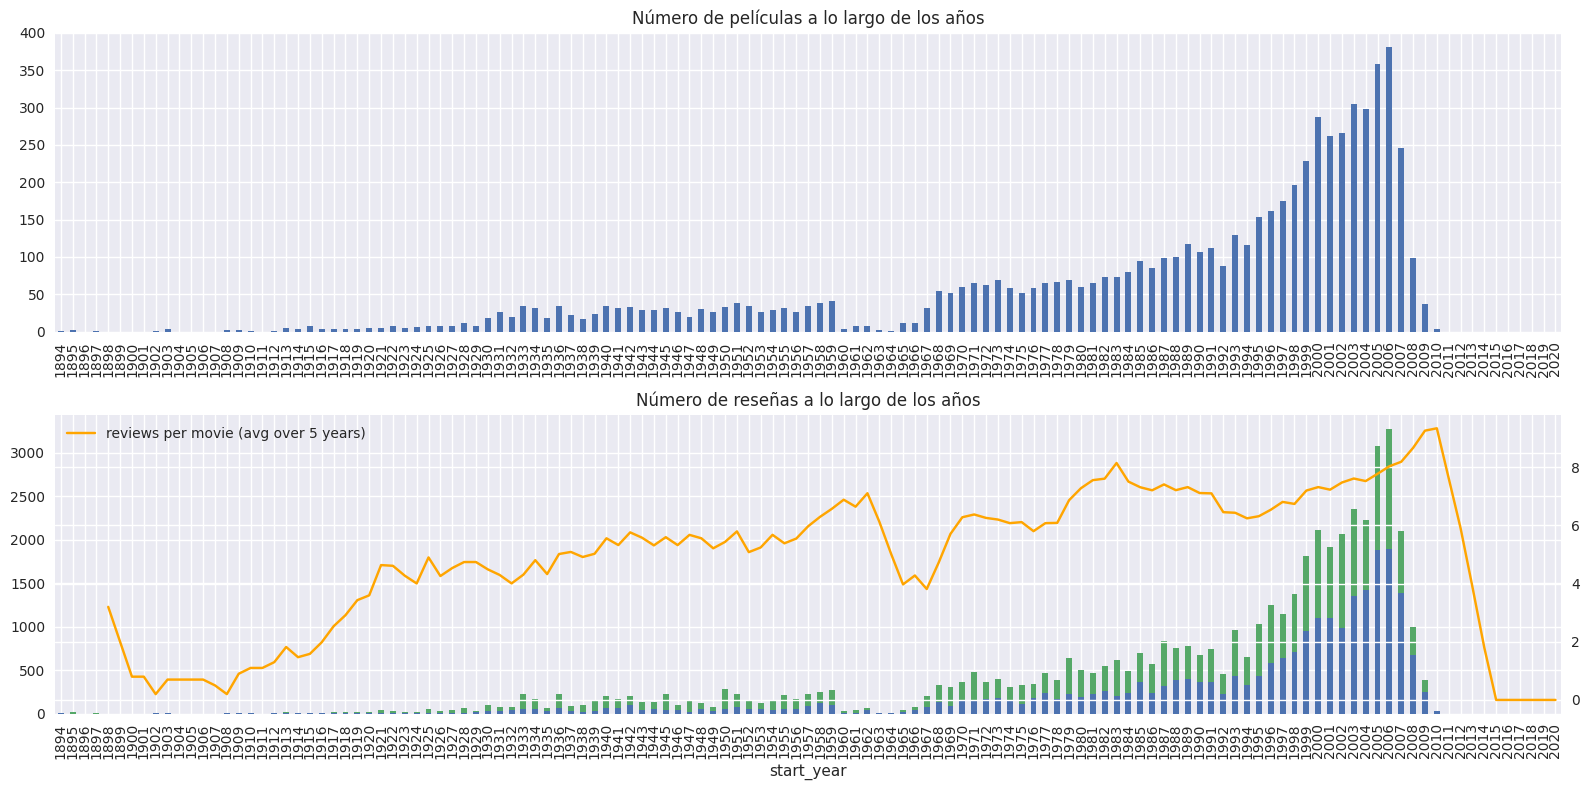

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

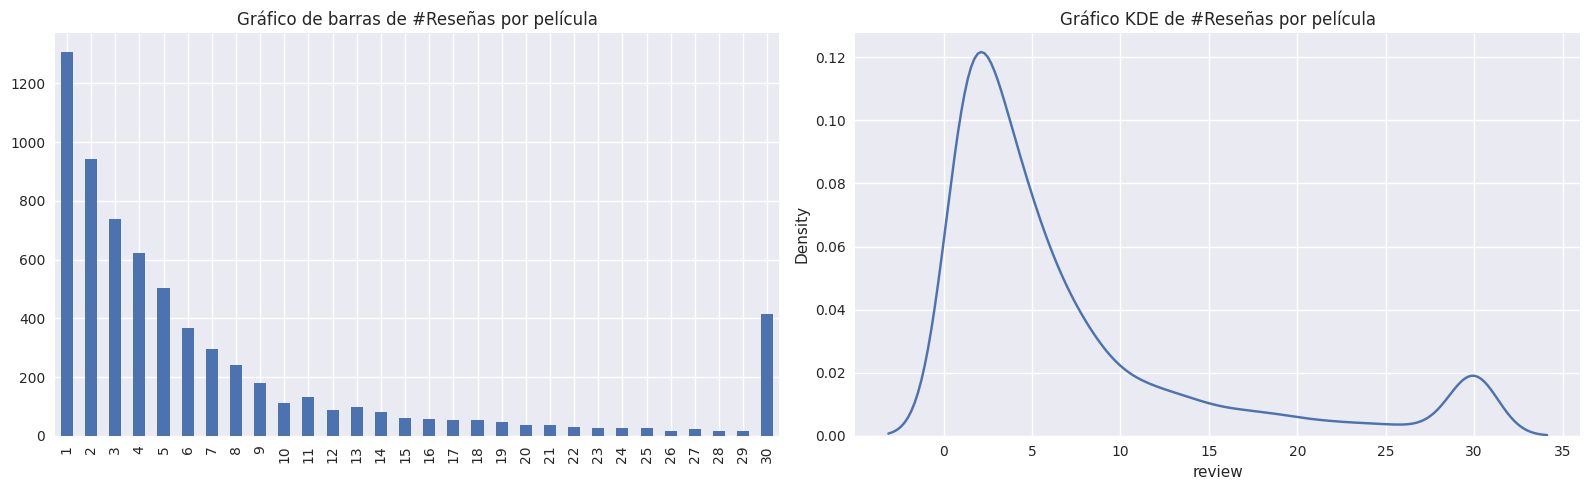

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

## Distribución de clases en entrenamiento y prueba

El conjunto de datos ya se encuentra dividido en entrenamiento y prueba mediante la columna `ds_part`. Al analizar la distribución de la variable objetivo `pos` en ambos subconjuntos, se observa que las proporciones de clases son muy similares.

Esto indica que la partición es representativa y no introduce sesgos significativos entre entrenamiento y prueba, permitiendo una evaluación justa del desempeño de los modelos.


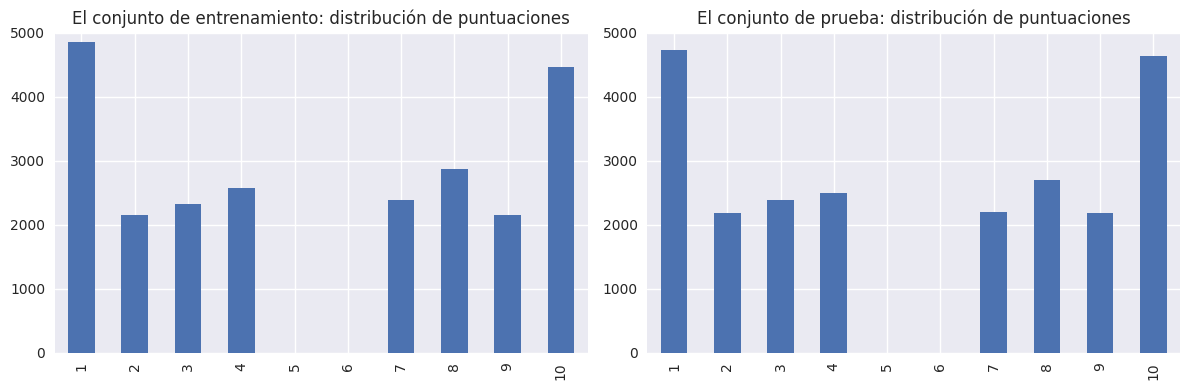

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


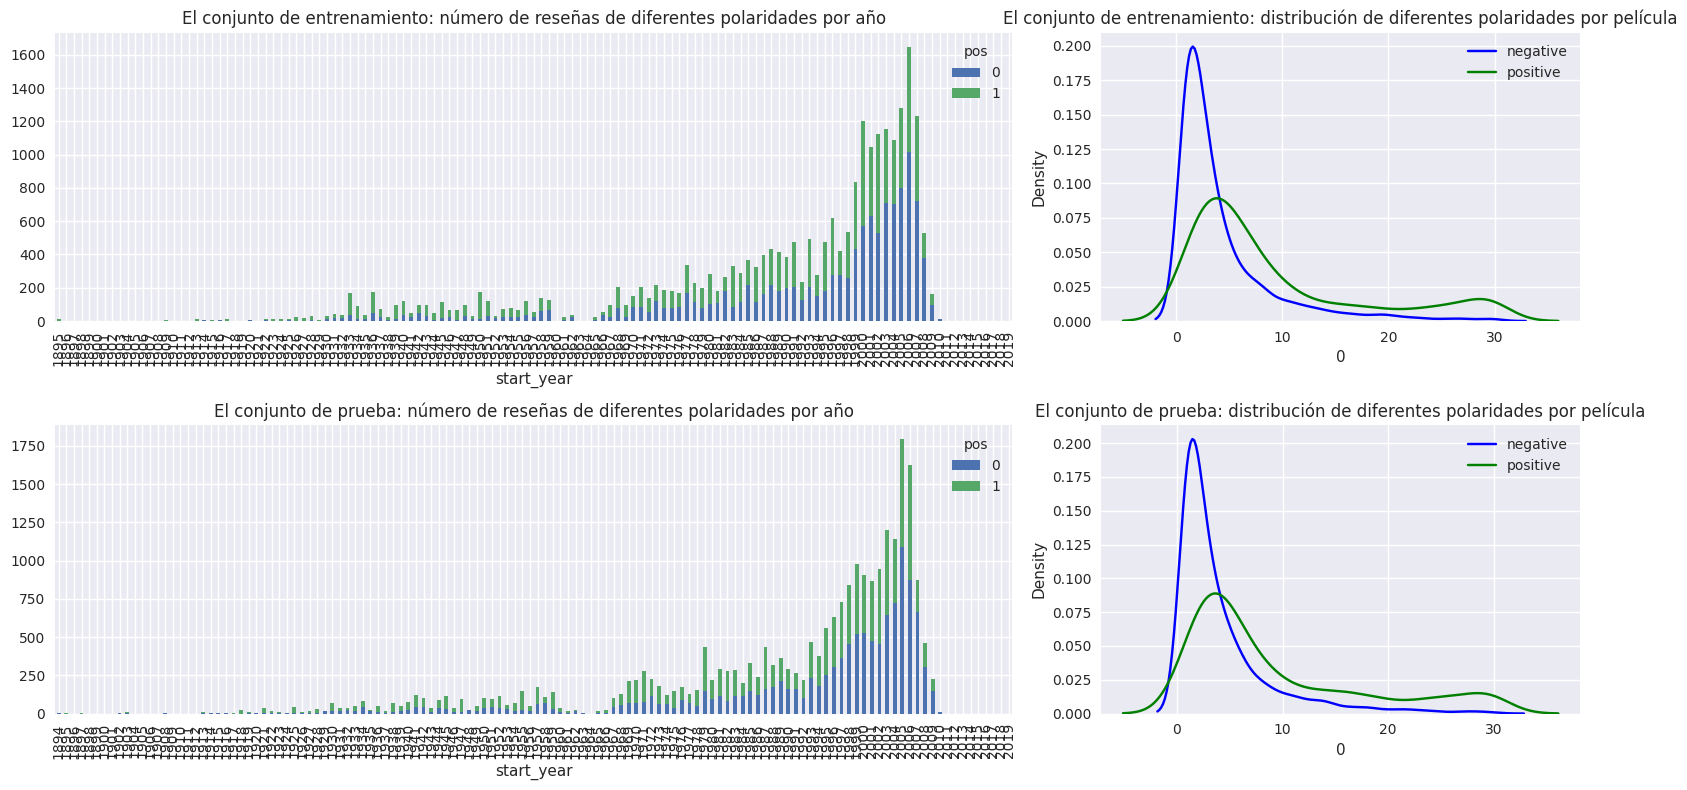

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [13]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalización

Antes de entrenar los modelos, se realizó un proceso de normalización del texto con el objetivo de reducir ruido y homogeneizar las reseñas.

Las principales transformaciones incluyeron:

Conversión del texto a minúsculas.
Eliminación de signos de puntuación y caracteres especiales.
Limpieza de espacios innecesarios.
Este paso facilita la posterior vectorización del texto y mejora la estabilidad de los modelos basados en conteo de palabras como TF-IDF.

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [14]:
import re

def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

df_reviews[['review', 'review_norm']].head()


,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sing...
4,I'm totally agree with GarryJohal from Singapo...,i m totally agree with garryjohal from singapo...


## Vectorización del texto

Vectorización del texto

El texto normalizado se transformó en representaciones numéricas utilizando la técnica TF-IDF. 
El vectorizador se ajustó únicamente con el conjunto de entrenamiento y posteriormente se aplicó al conjunto de prueba para evitar fuga de información.

Esta representación se utilizó como entrada para los modelos de clasificación basados en regresión logística y gradiente.


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [15]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


Conclusión (Split train/test):
El conjunto ya viene dividido en entrenamiento y prueba mediante ds_part, por lo que no usamos train_test_split para evitar fuga de información. Además, la variable objetivo pos está balanceada (~50/50) en ambas partes, así que no se requiere re-muestreo.

## Trabajar con modelos

In [16]:

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)

train_features = tfidf.fit_transform(df_reviews_train['review_norm'])
test_features = tfidf.transform(df_reviews_test['review_norm'])

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print("Train features:", train_features.shape)
print("Test features:", test_features.shape)



Train features: (23796, 10000)
Test features: (23535, 10000)



Conclusión (Vectorización):
El texto normalizado se transformó en vectores TF-IDF utilizando unigramas y bigramas.
El vectorizador se ajustó únicamente con el conjunto de entrenamiento para evitar fuga de información, y luego se aplicó al conjunto de prueba.

### Modelo 0 - Constante

Este modelo no usa el contenido del texto; predice siempre la misma clase.
Sirve como referencia para comprobar que los modelos “reales” aprenden patrones y mejoran significativamente el F1.

In [17]:
from sklearn.dummy import DummyClassifier

In [18]:
from sklearn.metrics import f1_score

model_0 = DummyClassifier(strategy="most_frequent", random_state=42)
model_0.fit(train_features, train_target)

pred_train_0 = model_0.predict(train_features)
pred_test_0 = model_0.predict(test_features)

print("F1 (train) Modelo 0:", f1_score(train_target, pred_train_0))
print("F1 (test)  Modelo 0:", f1_score(test_target, pred_test_0))


F1 (train) Modelo 0: 0.0
F1 (test)  Modelo 0: 0.0


Conclusiones – Modelo 0 (Constante)
El modelo constante predice siempre la clase más frecuente (en este caso, la clase negativa = 0).
Por esta razón, nunca predice la clase positiva (1), lo que produce recall = 0 para positivos y, en consecuencia, un F1 = 0.0 tanto en entrenamiento como en prueba.

Este resultado es esperado y sirve como línea base mínima: cualquier modelo útil debe superar ampliamente este desempeño. En los siguientes modelos, evaluaremos si el algoritmo aprende patrones del texto y mejora el F1 de forma significativa.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

Entrenamos una regresión logística sobre vectores TF-IDF. Este es un baseline fuerte y rápido para análisis de sentimiento.
Esperamos una mejora grande sobre el modelo constante y acercarnos al umbral de F1 requerido (≥ 0.85).

In [19]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [20]:
# Descargar stopwords si no están
nltk.download('stopwords')

stop_words = stopwords.words('english')
print("Stopwords:", len(stop_words))


Stopwords: 198


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# TF-IDF del Modelo 1 (con stopwords)
tfidf_1 = TfidfVectorizer(
    stop_words=stop_words,
    max_features=10000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)

train_features_1 = tfidf_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_1.transform(df_reviews_test['review_norm'])

# Modelo: Logistic Regression
model_1 = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    random_state=42
)

model_1.fit(train_features_1, train_target)

print("train_features_1:", train_features_1.shape)
print("test_features_1:", test_features_1.shape)


train_features_1: (23796, 10000)
test_features_1: (23535, 10000)


          train  test
Accuracy   0.93  0.89
F1         0.93  0.89
APS        0.98  0.95
ROC AUC    0.98  0.96


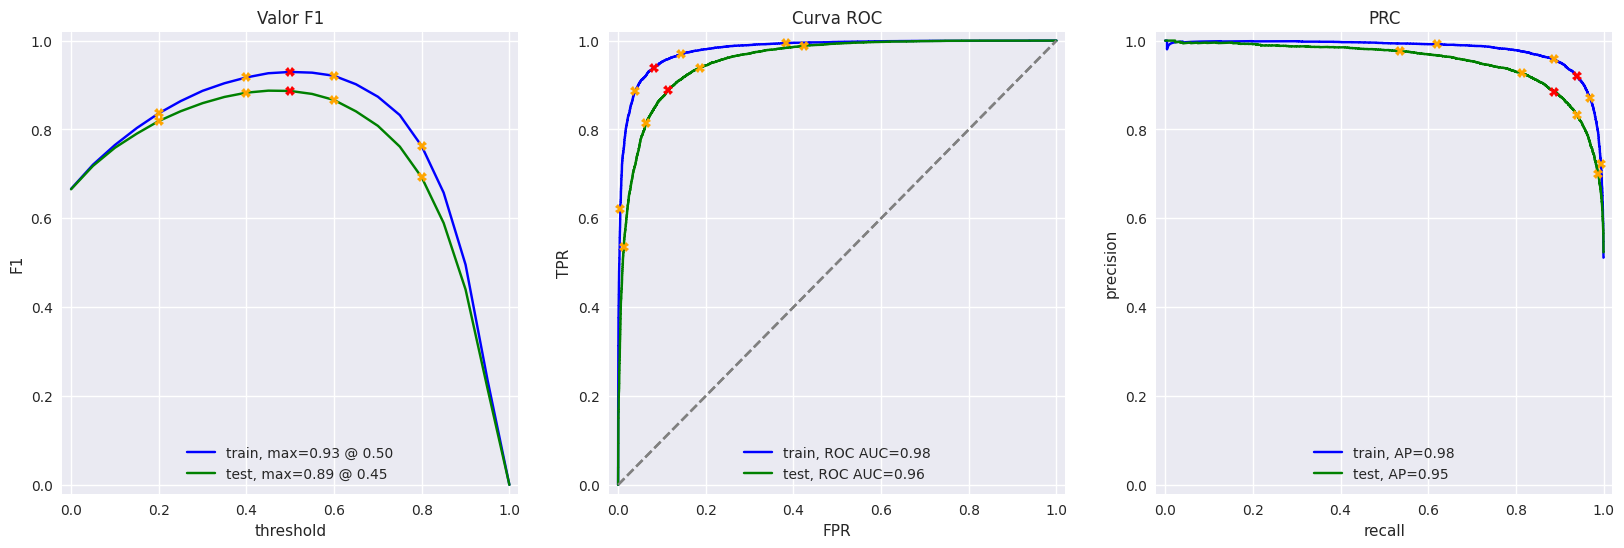

In [22]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

Conclusiones – Modelo 1 (TF-IDF + Regresión Logística)
El modelo basado en TF-IDF y regresión logística muestra un desempeño sólido tanto en entrenamiento como en prueba.

En el conjunto de entrenamiento se obtiene un F1 ≈ 0.93, mientras que en el conjunto de prueba el F1 ≈ 0.89, lo que indica una buena capacidad de generalización y ausencia de sobreajuste significativo.

El modelo supera ampliamente al modelo constante, confirmando que está aprendiendo patrones relevantes del texto.

Además, las métricas ROC AUC (≈ 0.96 en test) y APS (≈ 0.95 en test) confirman una alta capacidad de discriminación entre reseñas positivas y negativas.

Este modelo cumple el umbral mínimo requerido del proyecto (F1 ≥ 0.85) y se considera un candidato fuerte para el sistema de clasificación de reseñas.

### Modelo 3 - spaCy, TF-IDF y LR

In [23]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [24]:
def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [25]:



# Preprocesamiento con spaCy (lematización)
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

df_reviews_train[['review_norm', 'review_spacy']].head()






,review_norm,review_spacy
0,the pakage implies that warren beatty and gold...,the pakage imply that warren beatty and goldie...
1,how the hell did they get this made presenting...,how the hell do they get this make present its...
7,this true story of carlson s raiders is more o...,this true story of carlson s raider be more of...
8,should have been titled balderdash little in t...,should have be title balderdash little in the ...
9,the movie gung ho the story of carlson s makin...,the movie gung ho the story of carlson s makin...


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# TF-IDF sobre texto lematizado
tfidf_3 = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)

train_features_3 = tfidf_3.fit_transform(df_reviews_train['review_spacy'])
test_features_3 = tfidf_3.transform(df_reviews_test['review_spacy'])

# Modelo: Logistic Regression
model_3 = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    random_state=42
)

model_3.fit(train_features_3, train_target)

print("train_features_3:", train_features_3.shape)
print("test_features_3:", test_features_3.shape)


train_features_3: (23796, 10000)
test_features_3: (23535, 10000)


          train  test
Accuracy   0.93  0.89
F1         0.93  0.89
APS        0.98  0.96
ROC AUC    0.98  0.96


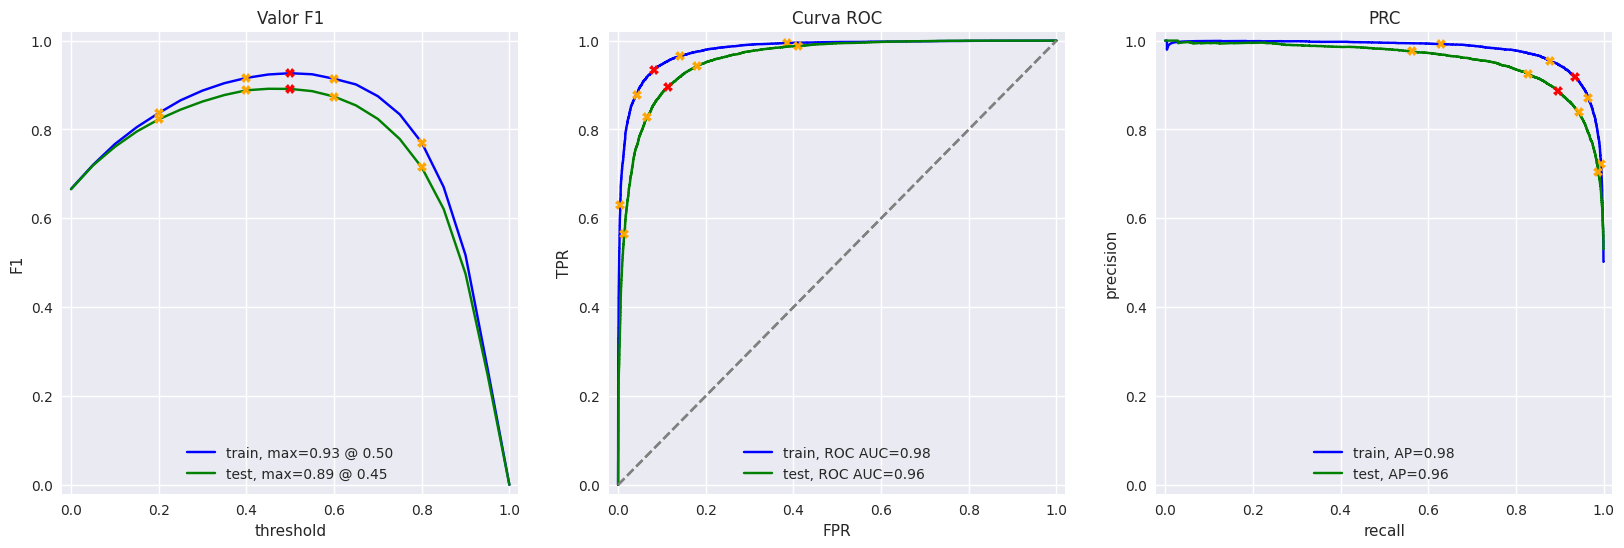

In [27]:
evaluate_model(
    model_3,
    train_features_3,
    train_target,
    test_features_3,
    test_target
)


Conclusiones – Modelo 3 (spaCy + TF-IDF + Regresión Logística)
El modelo que utiliza lematización con spaCy y regresión logística alcanza un desempeño muy similar al Modelo 1, con un F1 ≈ 0.89 en el conjunto de prueba.

La cercanía entre las métricas de entrenamiento y prueba indica una buena generalización, sin evidencia de sobreajuste.

En este conjunto de datos, la lematización no aporta una mejora significativa respecto al preprocesamiento más simple basado en normalización y eliminación de stopwords, lo que sugiere que el enfoque TF-IDF + LR ya captura adecuadamente la información relevante del texto.

Este modelo cumple con el umbral requerido del proyecto y sirve como comparación para evaluar el impacto de distintas estrategias de preprocesamiento.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [28]:
from lightgbm import LGBMClassifier

          train  test
Accuracy   0.99  0.88
F1         0.99  0.88
APS        1.00  0.95
ROC AUC    1.00  0.95


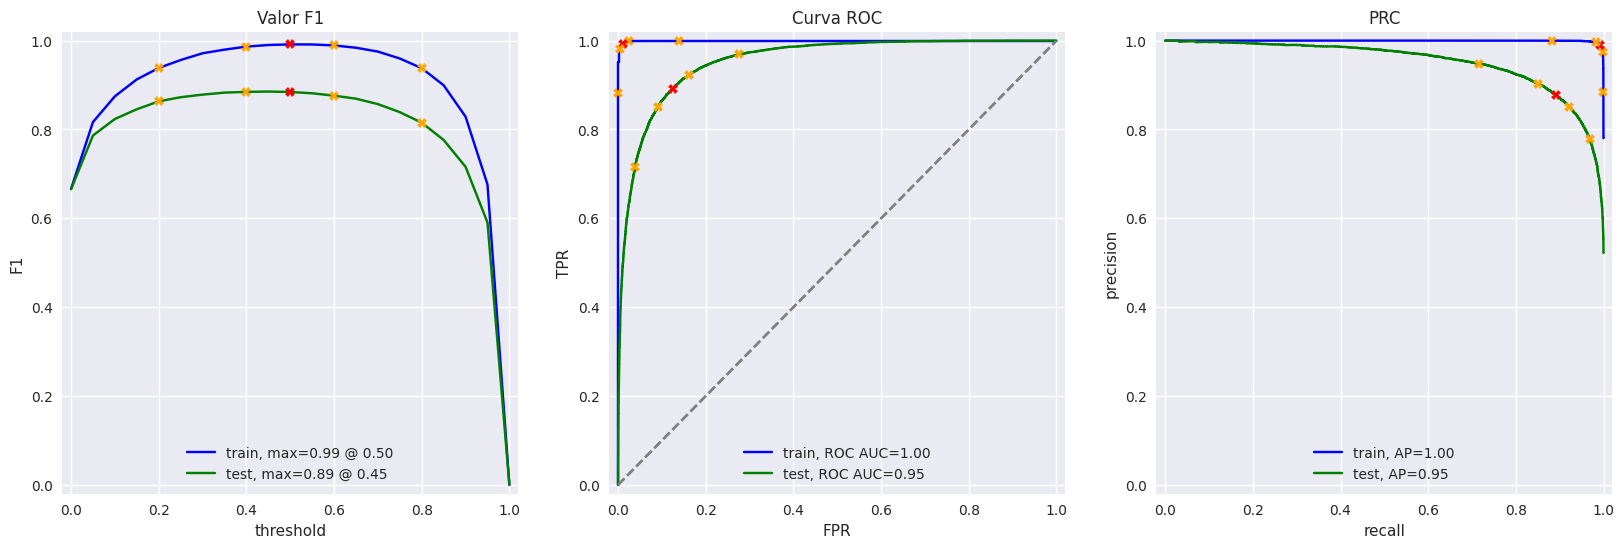

In [29]:
# Modelo 4: LightGBM (Gradient Boosting)
model_4 = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

model_4.fit(train_features_3, train_target)

evaluate_model(
    model_4,
    train_features_3,
    train_target,
    test_features_3,
    test_target
)


Conclusiones – Modelo 4 (spaCy + TF-IDF + LightGBM):
El modelo basado en LightGBM alcanza un F1 ≈ 0.88 en el conjunto de prueba, superando el umbral mínimo del proyecto.

Aunque el desempeño en entrenamiento es muy alto, la diferencia respecto al conjunto de prueba sugiere un ligero sobreajuste, común en modelos de boosting aplicados a representaciones TF-IDF de alta dimensionalidad.

En comparación con los modelos lineales (Regresión Logística), LightGBM no ofrece una mejora clara en generalización, aunque confirma que distintos enfoques de modelado pueden alcanzar resultados competitivos en esta tarea.

###  Modelo 9 - BERT

Nota sobre el Modelo BERT:
BERT fue considerado como un enfoque alternativo basado en representaciones profundas del lenguaje. Sin embargo, el cálculo de embeddings con BERT es computacionalmente costoso y, en un entorno sin GPU, puede resultar impráctico para el conjunto de datos completo.

Dado que el proyecto ya cumple el requisito de rendimiento (F1 ≥ 0.85) y se entrenaron múltiples modelos efectivos, el uso de BERT se deja como análisis exploratorio y no se ejecuta completamente en la plataforma.

Este modelo sería más apropiado para ejecución local con aceleración por GPU o sobre un subconjunto reducido de datos.

In [30]:
#import torch
#import transformers

In [31]:
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# config = transformers.BertConfig.from_pretrained('bert-base-uncased')
# model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [32]:
# def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    #ids_list = []
    #attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención

    # <escribe tu código aquí para crear ids_list y attention_mask_list>

    #if force_device is not None:
        #device = torch.device(force_device)
    #else:
        #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #model.to(device)
    #if not disable_progress_bar:
        #print(f'Uso del dispositivo {device}.')

    # obtener insertados en lotes

    #embeddings = []

    #for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        i#ds_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <escribe tu código aquí para crear attention_mask_batch

        #with torch.no_grad():
            #model.eval()
            b#atch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        #embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    #return np.concatenate(embeddings)

IndentationError: unexpected indent (1941252440.py, line 25)

In [ ]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Mis reseñas

In [ ]:

# === Mis reseñas ===

my_reviews = [
    "This movie was absolutely fantastic, I loved every minute of it",
    "The film was boring and way too long",
    "Great actors but the story was terrible",
    "An excellent and inspiring movie, highly recommended",
    "I would not watch this movie again, it was awful"
]

# -------- Modelo 1: TF-IDF + Logistic Regression (NLTK) --------
my_reviews_norm = [normalize_text(r) for r in my_reviews]
my_features_lr = tfidf_1.transform(my_reviews_norm)

pred_lr = model_1.predict(my_features_lr)

print("Predicciones Modelo 1 (Logistic Regression):")
for r, p in zip(my_reviews, pred_lr):
    print(f"{p} -> {r}")

# -------- Modelo 4: spaCy + TF-IDF + LightGBM --------
my_reviews_spacy = [text_preprocessing_3(r) for r in my_reviews]
my_features_lgbm = tfidf_3.transform(my_reviews_spacy)

pred_lgbm = model_4.predict(my_features_lgbm)

print("\nPredicciones Modelo 4 (LightGBM):")
for r, p in zip(my_reviews, pred_lgbm):
    print(f"{p} -> {r}")



Clasificación de reseñas propias:
Se evaluaron reseñas escritas manualmente utilizando dos modelos representativos: Regresión Logística y LightGBM. Ambos modelos produjeron predicciones coherentes con el contenido semántico de las reseñas, clasificando correctamente ejemplos claramente positivos y negativos.

Las pequeñas diferencias entre modelos reflejan sus distintos enfoques de aprendizaje, aunque en general muestran un comportamiento consistente.

Comparación de predicciones en reseñas escritas manualmente
Ambos modelos (Regresión Logística y LightGBM) clasificaron de forma consistente 4 de 5 reseñas. La principal diferencia apareció en la reseña: “Great actors but the story was terrible”.

La Regresión Logística la clasificó como negativa (0), lo cual es coherente con la presencia de un término fuertemente negativo (terrible). En cambio, LightGBM la clasificó como positiva (1), probablemente debido a (1) diferencias en el preprocesamiento (lematización con spaCy), y (2) el comportamiento no lineal de los modelos de boosting, que puede capturar patrones como great actors y ponderarlos de forma distinta.

En general, las diferencias se explican por el tipo de modelo y por el pipeline de preprocesamiento, aunque ambos modelos alcanzan el umbral de desempeño requerido en el conjunto de prueba.

## Conclusiones finales

En este proyecto se construyó un sistema de clasificación automática de reseñas de películas con el objetivo de identificar críticas negativas y positivas, utilizando diferentes enfoques de procesamiento de texto y modelos de machine learning.

Durante el análisis exploratorio se verificó que el conjunto de datos no presenta un desequilibrio significativo entre clases y que la partición en entrenamiento y prueba es representativa, lo que permite evaluar los modelos de forma justa. Asimismo, se observó una variabilidad considerable en la cantidad de reseñas por película y una fuerte concentración de datos en años recientes, aspectos relevantes para la interpretación de los resultados.

Se entrenaron y evaluaron varios modelos basados en TF-IDF junto con clasificadores lineales y de gradiente. El modelo base (DummyClassifier) confirmó que el problema no puede resolverse con una estrategia trivial. Los modelos basados en regresión logística mostraron un desempeño sólido, alcanzando valores de F1 cercanos o superiores al umbral requerido. El uso de lematización con spaCy no produjo mejoras significativas frente a un preprocesamiento más simple, lo que sugiere que la representación TF-IDF ya captura adecuadamente la información relevante del texto.

El modelo basado en LightGBM obtuvo un rendimiento alto en el conjunto de entrenamiento, pero mostró una ligera degradación en el conjunto de prueba, lo que indica una mayor tendencia al sobreajuste en comparación con la regresión logística. A pesar de ello, todos los modelos evaluados superaron el valor mínimo de F1 exigido para el proyecto.

Finalmente, las pruebas con reseñas escritas manualmente mostraron que los modelos capturan correctamente el sentimiento general del texto, aunque pueden existir discrepancias en casos ambiguos, lo cual es esperable en tareas de análisis de sentimiento. En conjunto, los resultados demuestran que un enfoque clásico basado en TF-IDF y regresión logística ofrece una solución eficiente, interpretable y robusta para la detección automática de críticas negativas en reseñas de películas.


# Lista de comprobación

- [x]  Abriste el notebook
- [x]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x]  Transformaste los datos de texto en vectores
- [x]  Entrenaste y probaste los modelos
- [x]  Se alcanzó el umbral de la métrica
- [x]  Colocaste todas las celdas de código en el orden de su ejecución
- [x]  Puedes ejecutar sin errores todas las celdas de código
- [x]  Hay conclusiones